In [1]:
#!python3 -m pip install cityscapesscripts

In [2]:
#!python -m pip install cityscapesscripts[gui]
# need it?

In [1]:
from PIL import Image
from cityscapesscripts.helpers import labels
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import time
import gc
from tqdm.auto import tqdm
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup

In [2]:
# Set seeds for reproducibility
def set_seeds(seed=42):
    """Set seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
SEED = 42
set_seeds(SEED)
print(f"Seeds set for reproducibility is {SEED}")

Seeds set for reproducibility is 42


In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() 
                      else "mps" if torch.mps.is_available() 
                      else "cpu"
                    )
print(DEVICE)

mps


Actual Colors:


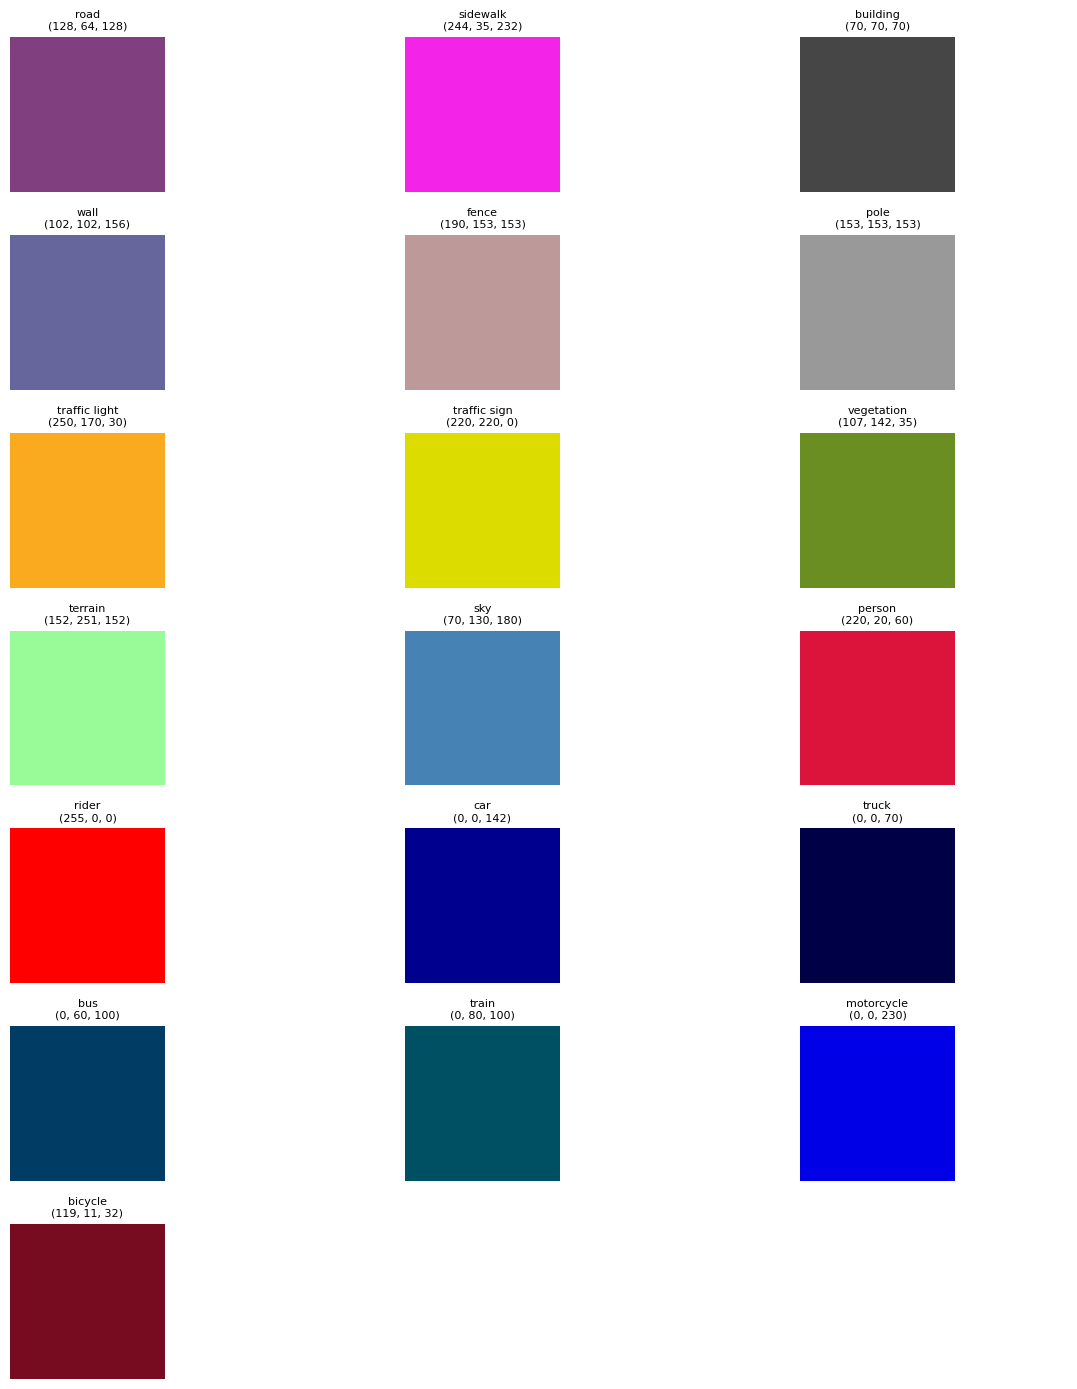

In [4]:
print("Actual Colors:")

# Calculate grid dimensions (3 colors per row)
cols = 3

labels = [label for label in labels.labels if label.trainId != 255 and label.trainId != -1]
rows = (len(labels) + cols - 1) // cols  # Ceiling division

# Create a figure and axes to display the colors in a grid
fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 2))

# Flatten axes array for easier indexing
if rows == 1:
    axes = [axes] if cols == 1 else axes
else:
    axes = axes.flatten()

for i, label in enumerate(labels): 
    color = np.array(label.color) / 255.0  # Normalize RGB values to [0, 1]
    axes[i].imshow([[color]])  # Display the color as a small image
    # Add color name and RGB values to the title
    axes[i].set_title(f"{label.name}\n{label.color}", fontsize=8)
    axes[i].axis('off')  # Hide the axes

# Hide any unused subplots
for i in range(len(labels), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [4]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, targets_dir, image_transform=None, target_transform=None):
        """
        Args:
            images_dir (string): Directory with all the images.
            targets_dir (string): Directory with all the target masks.
            image_transform (callable, optional): Optional transform to be applied on images.
            target_transform (callable, optional): Optional transform to be applied on targets.
        """
        self.images_dir = images_dir
        self.targets_dir = targets_dir
        self.image_transform = image_transform
        self.target_transform = target_transform
        
        # Get all image filenames
        self.image_filenames = [f for f in os.listdir(images_dir) 
                               if f.lower().endswith(('.png'))]
        self.image_filenames.sort()
        
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        # Load image
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        # Load target mask
        target_name = img_name.replace('.png', '_trainId.png')
        target_path = os.path.join(self.targets_dir, target_name)
        target = Image.open(target_path)
        
        # Apply transforms
        if self.image_transform:
            image = self.image_transform(image)
        
        if self.target_transform:
            target = self.target_transform(target)
       # else:
       #     # Default: convert to tensor
       #     target = torch.from_numpy(target)
        
        return image, target

In [5]:
path_images = "syn_resized_images"
path_target = "syn_resized_gt"

image_transform = transforms.Compose([
    transforms.Resize((256, 466)), # We maintain the og aspect ratio
    transforms.ToTensor(),  # Converts PIL Image to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize with ImageNet parameters
])

target_transform = transforms.Compose([
    transforms.Resize((256, 466), interpolation=Image.NEAREST), # This interpolation ensure that all pixels have a correct value of their class
    transforms.Lambda(lambda x: torch.from_numpy(np.array(x)).long())
])
syn_dataset = SegmentationDataset(images_dir=path_images, targets_dir=path_target, image_transform=image_transform, target_transform=target_transform)


In [6]:
# Get total dataset size
total_size = len(syn_dataset)
print(f"Total dataset size: {total_size}")

# Calculate split sizes (60% train, 10% val, 30% test)
train_size = int(0.6 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

print(f"Train size: {train_size} ({train_size/total_size*100:.1f}%)")
print(f"Validation size: {val_size} ({val_size/total_size*100:.1f}%)")
print(f"Test size: {test_size} ({test_size/total_size*100:.1f}%)")

# Create random splits
syn_train_dataset, syn_val_dataset, syn_test_dataset = random_split(
    syn_dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(SEED)  # For reproducibility
)

# Create DataLoaders
batch_size = 8  


syn_train_dataloader = DataLoader(
    syn_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    #num_workers=2,
    generator=torch.Generator().manual_seed(SEED) 
)


syn_val_dataloader = DataLoader(
    syn_val_dataset,
    batch_size=batch_size,
    shuffle=True,  
    #num_workers=2,
    generator=torch.Generator().manual_seed(SEED)
)

syn_test_dataloader = DataLoader(
    syn_test_dataset,
    batch_size=batch_size,
    shuffle=True,  
    #num_workers=2,
    generator=torch.Generator().manual_seed(SEED)
)

print(f"\nDataLoaders created:")
print(f"Train batches: {len(syn_train_dataloader)}")
print(f"Validation batches: {len(syn_val_dataloader)}")
print(f"Test batches: {len(syn_test_dataloader)}")

Total dataset size: 12500
Train size: 7500 (60.0%)
Validation size: 1250 (10.0%)
Test size: 3750 (30.0%)

DataLoaders created:
Train batches: 938
Validation batches: 157
Test batches: 469


In [7]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=0.1, ignore_index=None):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.ignore_index = ignore_index

    def forward(self, inputs, targets):
        """
        inputs: (N, C, H, W) - logits (non softmaxati)
        targets: (N, H, W)   - ground truth con classi (0...C-1)
        """
        num_classes = inputs.shape[1]
        device = inputs.device  # Get device from input tensor
        
        # Softmax sulle predizioni
        probs = F.softmax(inputs, dim=1)  # (N, C, H, W)
        
        # Handle ignore_index by creating a mask and filtering out ignored pixels
        if self.ignore_index is not None:
            # Create mask for valid pixels
            valid_mask = (targets != self.ignore_index)  # (N, H, W)
            
            # Only process valid pixels
            valid_targets = targets[valid_mask]  # (N_valid,)
            
            # Reshape probs to match and filter valid pixels
            probs_reshaped = probs.permute(0, 2, 3, 1)  # (N, H, W, C)
            valid_probs = probs_reshaped[valid_mask]  # (N_valid, C)
            
        else:
            # No ignore_index, process all pixels
            valid_targets = targets.view(-1)  # (N*H*W,)
            valid_probs = probs.permute(0, 2, 3, 1).contiguous().view(-1, num_classes)  # (N*H*W, C)
        
        # One-hot encoding of valid targets only
        if len(valid_targets) > 0:
            targets_one_hot = F.one_hot(valid_targets, num_classes=num_classes).float()  # (N_valid, C)
        else:
            # If no valid pixels, create a zero loss that maintains gradients
            # Use a small operation on the input to maintain gradient flow
            zero_loss = (inputs * 0.0).sum()  # This maintains gradients from inputs
            return zero_loss
        
        # Calcolo Dice per ogni classe usando solo pixel validi
        intersection = (valid_probs * targets_one_hot).sum(dim=0)  # (C,)
        union = valid_probs.sum(dim=0) + targets_one_hot.sum(dim=0)  # (C,)
        
        
        smooth_tensor = torch.tensor(self.smooth, device=device, dtype=intersection.dtype)
        dice = (2.0 * intersection + smooth_tensor) / (union + smooth_tensor)
        
        # Media sulle classi
        loss = 1.0 - dice.mean()
        return loss

In [8]:
import ssl
import urllib.request
from contextlib import contextmanager
# Disable SSL verification for urllib requests on MacOS
# This is a workaround for the "SSL: CERTIFICATE_VERIFY_FAILED" error on MacOS
@contextmanager
def no_ssl_verification():
    """Temporarily disable SSL verification"""
    old_context = ssl._create_default_https_context
    ssl._create_default_https_context = ssl._create_unverified_context
    try:
        yield
    finally:
        ssl._create_default_https_context = old_context
        
if DEVICE.type == 'mps': 
    print("mps detected, using no_ssl_verification")
    with no_ssl_verification():
        model = deeplabv3_resnet50(
            weights='COCO_WITH_VOC_LABELS_V1', 
        )
else:
    model = deeplabv3_resnet50(
        weights='COCO_WITH_VOC_LABELS_V1', 
    )
NUM_CLASSES = 19  # Cityscapes
LR = 1e-4

model.classifier[4] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
model = model.to(DEVICE)

CE_loss = nn.CrossEntropyLoss(ignore_index=255)  # 255 = unlabeled
Dice_loss = DiceLoss(smooth=0.1, ignore_index=255)  


importance = 0.7

def criterion(outputs, targets):
    ce_loss = CE_loss(outputs, targets)
    dice_loss = Dice_loss(outputs, targets)
    return importance * ce_loss + (1 - importance) * dice_loss

optimizer = optim.Adam(model.parameters(), lr=LR)


mps detected, using no_ssl_verification


In [9]:
def compute_iou(preds, labels, num_classes, ignore_index=255):
    
    preds = torch.argmax(preds, dim=1).detach().cpu()  # [B, H, W]
    
    labels = labels.detach().cpu() 
    
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (labels == cls)
        
        # Escludi pixel ignorati
        mask = (labels != ignore_index)
        pred_inds = pred_inds & mask
        target_inds = target_inds & mask

        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        
        if union == 0:
            continue  # salta classe non presente
        ious.append(intersection / union)
    
    if len(ious) == 0:
        return float('nan')  # o 0.0 se preferisci
    return sum(ious) / len(ious)

In [10]:
def train_and_validate_epoch(model, train_dataloader, val_dataloader, optimizer, criterion):
    """
    Train for one epoch and validate on validation set with memory management
    Returns: train_loss, train_iou, val_loss, val_iou
    """
    # Training phase
    model.train()
    train_total_loss = 0
    train_total_iou = 0
    
    for i, (images, masks) in enumerate(tqdm(train_dataloader, desc="Training")):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()  
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        # Collect metrics (detach to prevent graph retention)
        train_total_loss += loss.detach().cpu().item()
        # Pass both outputs and masks to compute_iou, which will handle device conversion
        iou_value = compute_iou(outputs, masks, NUM_CLASSES)
        train_total_iou += iou_value
        
        # Explicit cleanup of tensors to prevent memory leaks
        del images, masks, outputs, loss
        
        # Periodically clear memory (every 5 batches)
        if (i + 1) % 5 == 0:
            clear_memory()  
    
    
    clear_memory()
    
    train_avg_loss = train_total_loss / len(train_dataloader)
    train_avg_iou = train_total_iou / len(train_dataloader)
    
    # Validation 
    model.eval()
    val_total_loss = 0
    val_total_iou = 0
    
    with torch.no_grad():
        for i, (images, masks) in enumerate(tqdm(val_dataloader, desc="Validating")):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            
            # Collect metrics
            val_total_loss += loss.detach().cpu().item()
            # Let compute_iou handle the device conversion
            val_total_iou += compute_iou(outputs, masks, NUM_CLASSES)
            
            # Explicit cleanup
            del images, masks, outputs, loss
            
            # Periodic memory clear
            if (i + 1) % 5 == 0:
                clear_memory()
    
    clear_memory()
    
    val_avg_loss = val_total_loss / len(val_dataloader)
    val_avg_iou = val_total_iou / len(val_dataloader)
    
    return train_avg_loss, train_avg_iou, val_avg_loss, val_avg_iou

In [11]:
def clear_memory():
    """Clear memory and cache for all device types"""
    # Delete all local variables in the caller's frame
    for obj in list(locals().values()):
        del obj
        
    # Run garbage collector
    gc.collect()
    
    if DEVICE.type == 'cuda':
        torch.cuda.empty_cache()

    if DEVICE.type == 'mps':
        torch.mps.empty_cache()

    # Second GC run to make sure everything is cleaned up
    gc.collect()

# Training

In [ ]:
epochs = 15

# Create models directory if it doesn't exist
import os
os.makedirs("models", exist_ok=True)

# Store metrics for plotting
train_losses = []
train_ious = []
val_losses = []
val_ious = []

# Track best validation IoU for saving best model
best_val_iou = 0.0
start = time.time()

set_seeds(SEED)
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    # Train and validate in one go
    train_loss, train_iou, val_loss, val_iou = train_and_validate_epoch(
        model, syn_train_dataloader, syn_val_dataloader, optimizer, criterion
    )
    
    # Store metrics
    train_losses.append(train_loss)  
    train_ious.append(train_iou)
    val_losses.append(val_loss)
    val_ious.append(val_iou)
    
    # Print results
    print(f"Train Loss: {train_loss:.4f} | Train IoU: {train_iou:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val IoU: {val_iou:.4f}")
    
    # Save checkpoint after each epoch
    checkpoint = {
        "epoch": epoch + 1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "train_loss": train_loss,
        "train_iou": train_iou,
        "val_loss": val_loss,
        "val_iou": val_iou,
        "train_losses": train_losses,
        "train_ious": train_ious,
        "val_losses": val_losses,
        "val_ious": val_ious,
        "num_classes": NUM_CLASSES,
        "learning_rate": LR,
    }
    
    
    # Save best model based on validation IoU
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        best_model_path = "models/deeplabv3_resnet50_best_model.pth"
        torch.save(checkpoint, best_model_path)
        print(f"New best model saved: {best_model_path} (Val IoU: {val_iou:.4f})")
    
    checkpoint_path = f"models/deeplabv3_resnet50_epoch_{epoch+1}.pth"
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")

    # Delete old checkpoints if they exist
    checkpoint_delete = f"models/deeplabv3_resnet50_epoch_{epoch}.pth"
    if os.path.exists(checkpoint_delete):
        os.remove(checkpoint_delete)
        print(f"Deleted old checkpoint: {checkpoint_delete}")
    
    del checkpoint
    print("-" * 50)
    
end = time.time()
print(f"\nTraining completed in {end - start:.2f} seconds, with {epochs} epochs.")
print(f"Best validation IoU: {best_val_iou:.4f}")
print(f"Final model saved as: models/deeplabv3_resnet50_epoch_{epochs}.pth")
print(f"Best model saved as: models/deeplabv3_resnet50_best_model.pth")

Epoch 1/15


Validating: 100%|██████████| 125/125 [02:30<00:00,  1.21s/it]


Train Loss: 0.6286 | Train IoU: 0.3453
Val Loss: 0.4283 | Val IoU: 0.4171
New best model saved: models/deeplabv3_resnet50_best_model.pth (Val IoU: 0.4171)
Checkpoint saved: models/deeplabv3_resnet50_epoch_1.pth
--------------------------------------------------
Epoch 2/15


Validating: 100%|██████████| 125/125 [02:32<00:00,  1.22s/it]


Train Loss: 0.3936 | Train IoU: 0.4489
Val Loss: 0.3671 | Val IoU: 0.4700
New best model saved: models/deeplabv3_resnet50_best_model.pth (Val IoU: 0.4700)
Checkpoint saved: models/deeplabv3_resnet50_epoch_2.pth
Deleted old checkpoint: models/deeplabv3_resnet50_epoch_1.pth
--------------------------------------------------
Epoch 3/15


Validating: 100%|██████████| 125/125 [02:28<00:00,  1.19s/it]


Train Loss: 0.3384 | Train IoU: 0.5052
Val Loss: 0.3443 | Val IoU: 0.4963
New best model saved: models/deeplabv3_resnet50_best_model.pth (Val IoU: 0.4963)
Checkpoint saved: models/deeplabv3_resnet50_epoch_3.pth
Deleted old checkpoint: models/deeplabv3_resnet50_epoch_2.pth
--------------------------------------------------
Epoch 4/15


Validating: 100%|██████████| 125/125 [02:29<00:00,  1.20s/it]


Train Loss: 0.3048 | Train IoU: 0.5412
Val Loss: 0.3341 | Val IoU: 0.5091
New best model saved: models/deeplabv3_resnet50_best_model.pth (Val IoU: 0.5091)
Checkpoint saved: models/deeplabv3_resnet50_epoch_4.pth
Deleted old checkpoint: models/deeplabv3_resnet50_epoch_3.pth
--------------------------------------------------
Epoch 5/15


Validating: 100%|██████████| 125/125 [02:33<00:00,  1.23s/it]


Train Loss: 0.2780 | Train IoU: 0.5707
Val Loss: 0.3110 | Val IoU: 0.5194
New best model saved: models/deeplabv3_resnet50_best_model.pth (Val IoU: 0.5194)
Checkpoint saved: models/deeplabv3_resnet50_epoch_5.pth
Deleted old checkpoint: models/deeplabv3_resnet50_epoch_4.pth
--------------------------------------------------
Epoch 6/15


Validating: 100%|██████████| 125/125 [02:43<00:00,  1.31s/it]


Train Loss: 0.2621 | Train IoU: 0.5899
Val Loss: 0.2983 | Val IoU: 0.5491
New best model saved: models/deeplabv3_resnet50_best_model.pth (Val IoU: 0.5491)
Checkpoint saved: models/deeplabv3_resnet50_epoch_6.pth
Deleted old checkpoint: models/deeplabv3_resnet50_epoch_5.pth
--------------------------------------------------
Epoch 7/15


Validating: 100%|██████████| 125/125 [02:48<00:00,  1.35s/it]


Train Loss: 0.2594 | Train IoU: 0.5955
Val Loss: 0.2959 | Val IoU: 0.5491
Checkpoint saved: models/deeplabv3_resnet50_epoch_7.pth
Deleted old checkpoint: models/deeplabv3_resnet50_epoch_6.pth
--------------------------------------------------
Epoch 8/15


Validating: 100%|██████████| 125/125 [03:34<00:00,  1.72s/it]


Train Loss: 0.2407 | Train IoU: 0.6130
Val Loss: 0.2831 | Val IoU: 0.5616
New best model saved: models/deeplabv3_resnet50_best_model.pth (Val IoU: 0.5616)
Checkpoint saved: models/deeplabv3_resnet50_epoch_8.pth
Deleted old checkpoint: models/deeplabv3_resnet50_epoch_7.pth
--------------------------------------------------
Epoch 9/15


Validating: 100%|██████████| 125/125 [03:53<00:00,  1.87s/it]


Train Loss: 0.2262 | Train IoU: 0.6094
Val Loss: 0.2887 | Val IoU: 0.5468
Checkpoint saved: models/deeplabv3_resnet50_epoch_9.pth
Deleted old checkpoint: models/deeplabv3_resnet50_epoch_8.pth
--------------------------------------------------
Epoch 10/15


Validating: 100%|██████████| 125/125 [05:59<00:00,  2.87s/it]


Train Loss: 0.2163 | Train IoU: 0.6170
Val Loss: 0.2776 | Val IoU: 0.5488
Checkpoint saved: models/deeplabv3_resnet50_epoch_10.pth
Deleted old checkpoint: models/deeplabv3_resnet50_epoch_9.pth
--------------------------------------------------
Epoch 11/15


Validating: 100%|██████████| 125/125 [06:14<00:00,  3.00s/it]


Train Loss: 0.2046 | Train IoU: 0.6264
Val Loss: 0.2629 | Val IoU: 0.5663
New best model saved: models/deeplabv3_resnet50_best_model.pth (Val IoU: 0.5663)
Checkpoint saved: models/deeplabv3_resnet50_epoch_11.pth
Deleted old checkpoint: models/deeplabv3_resnet50_epoch_10.pth
--------------------------------------------------
Epoch 12/15


Validating: 100%|██████████| 125/125 [07:07<00:00,  3.42s/it]


Train Loss: 0.1930 | Train IoU: 0.6408
Val Loss: 0.2662 | Val IoU: 0.5700
New best model saved: models/deeplabv3_resnet50_best_model.pth (Val IoU: 0.5700)
Checkpoint saved: models/deeplabv3_resnet50_epoch_12.pth
Deleted old checkpoint: models/deeplabv3_resnet50_epoch_11.pth
--------------------------------------------------
Epoch 13/15


Validating: 100%|██████████| 125/125 [08:55<00:00,  4.28s/it]


Train Loss: 0.1869 | Train IoU: 0.6487
Val Loss: 0.2649 | Val IoU: 0.5705
New best model saved: models/deeplabv3_resnet50_best_model.pth (Val IoU: 0.5705)
Checkpoint saved: models/deeplabv3_resnet50_epoch_13.pth
Deleted old checkpoint: models/deeplabv3_resnet50_epoch_12.pth
--------------------------------------------------
Epoch 14/15


Validating: 100%|██████████| 125/125 [11:24<00:00,  5.48s/it]


Train Loss: 0.1837 | Train IoU: 0.6529
Val Loss: 0.2743 | Val IoU: 0.5562
Checkpoint saved: models/deeplabv3_resnet50_epoch_14.pth
Deleted old checkpoint: models/deeplabv3_resnet50_epoch_13.pth
--------------------------------------------------
Epoch 15/15


Validating: 100%|██████████| 125/125 [15:35<00:00,  7.49s/it]


Train Loss: 0.1791 | Train IoU: 0.6560
Val Loss: 0.2608 | Val IoU: 0.5710
New best model saved: models/deeplabv3_resnet50_best_model.pth (Val IoU: 0.5710)
Checkpoint saved: models/deeplabv3_resnet50_epoch_15.pth
Deleted old checkpoint: models/deeplabv3_resnet50_epoch_14.pth
--------------------------------------------------

Training completed in 57737.70 seconds, with 15 epochs.
Best validation IoU: 0.5710
Final model saved as: models/deeplabv3_resnet50_epoch_15.pth
Best model saved as: models/deeplabv3_resnet50_best_model.pth


# Visualization

In [12]:
# Create color map for segmentation (using Cityscapes colors)
from cityscapesscripts.helpers import labels as cs_labels
def visualize_segmentation(model, dataloader, num_samples=4):
    """
    Visualize segmentation results from the model
    """
    model.eval()
    
    # Get a batch of data
    images, targets = next(iter(dataloader))
    images = images.to(DEVICE)
    targets = targets.to(DEVICE)
    
    with torch.no_grad():
        outputs = model(images)['out']
        predictions = torch.argmax(outputs, dim=1)
    
    # Move to CPU for visualization
    images = images.cpu()
    targets = targets.cpu()
    predictions = predictions.cpu()
    

    
    def apply_color_map(seg_map):
        """Apply color mapping to segmentation map"""
        colored_map = np.zeros((seg_map.shape[0], seg_map.shape[1], 3), dtype=np.uint8)
        
        # Get valid labels (excluding ignore classes)
        valid_labels = [label for label in cs_labels.labels if label.trainId != 255 and label.trainId != -1]
        
        for label in valid_labels:
            mask = seg_map == label.trainId
            colored_map[mask] = label.color
            
        return colored_map
    
    # Plot results
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 4))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(min(num_samples, len(images))):
        # Original image
        img = images[i].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # Normalize for display
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')
        
        # Ground truth
        gt_colored = apply_color_map(targets[i].numpy())
        axes[i, 1].imshow(gt_colored)
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')
        
        # Prediction
        pred_colored = apply_color_map(predictions[i].numpy())
        axes[i, 2].imshow(pred_colored)
        axes[i, 2].set_title('Prediction')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()


Visualizing segmentation results...


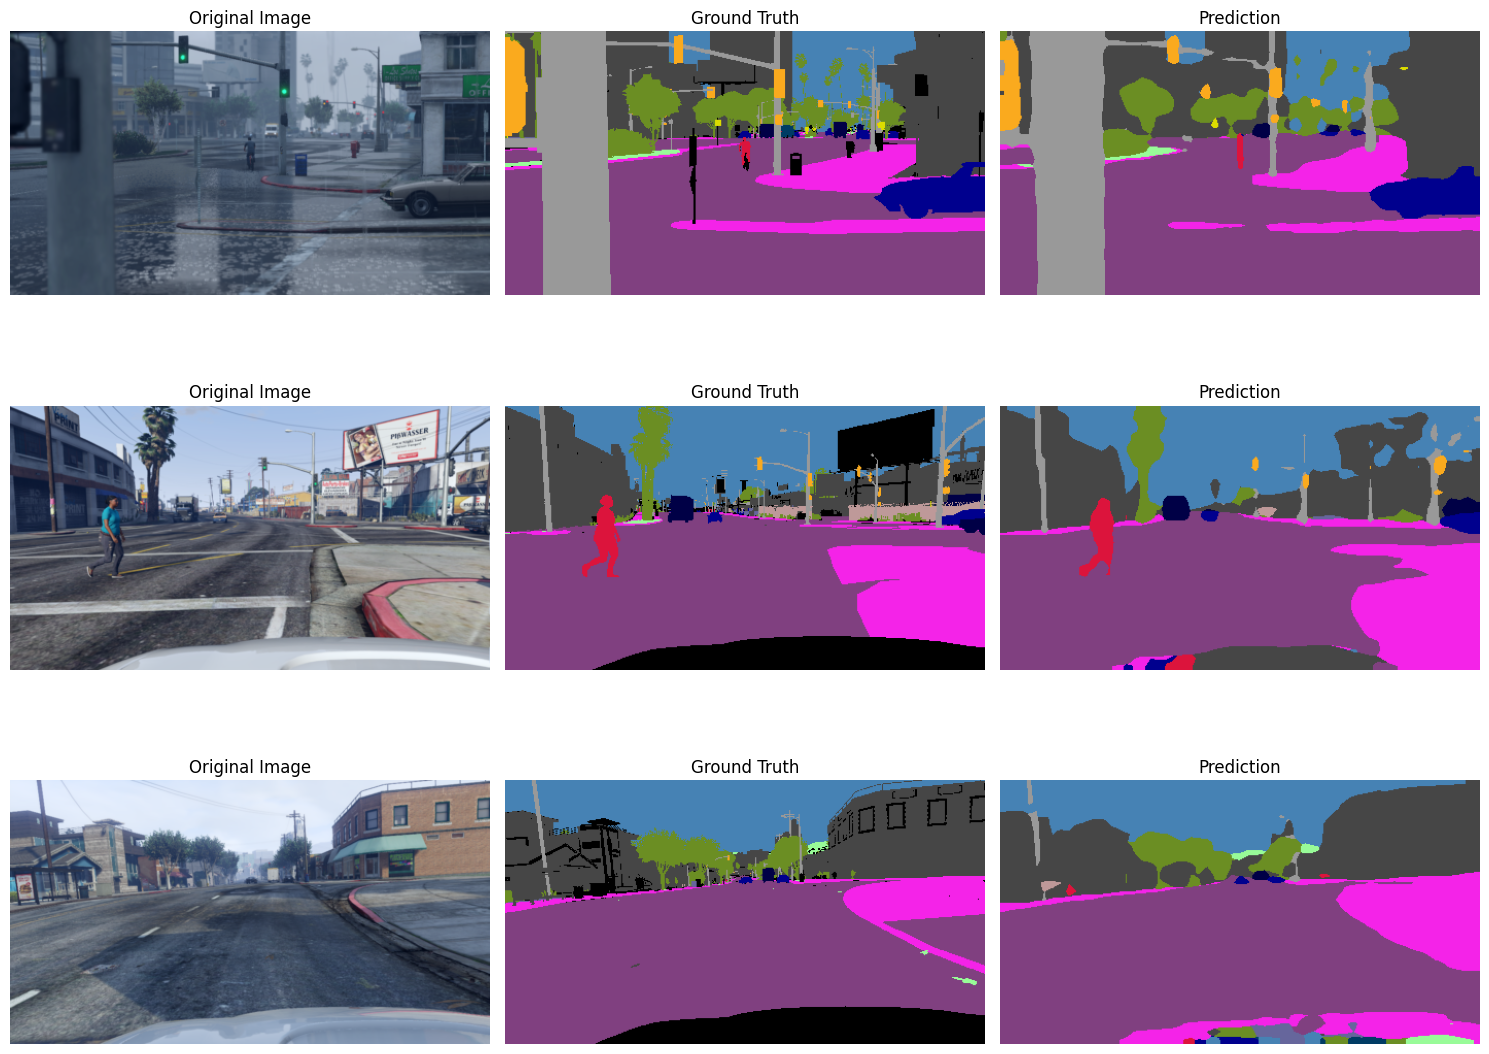


Training examples:


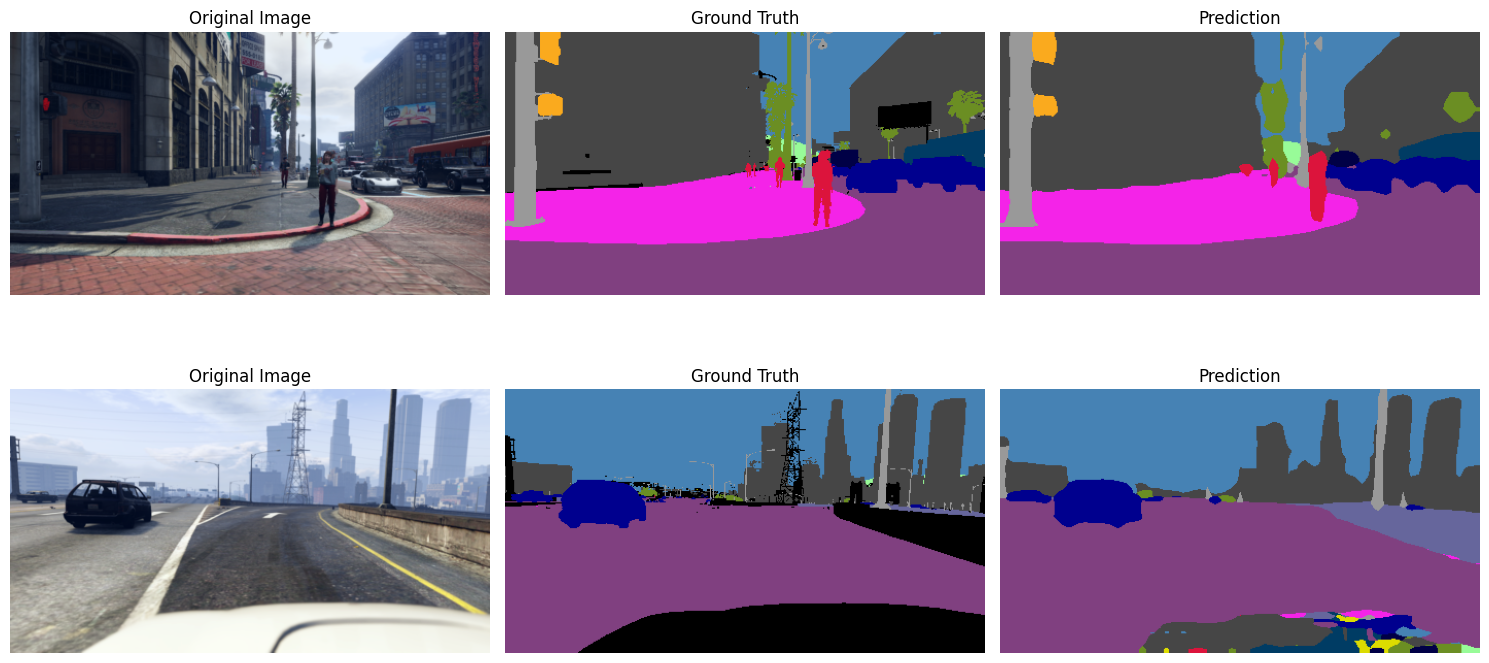

In [ ]:
# Visualize segmentation results on validation set
print("Visualizing segmentation results...")
visualize_segmentation(model, syn_val_dataloader, num_samples=3)

# Also show some training examples for comparison
print("\nTraining examples:")
visualize_segmentation(model, syn_train_dataloader, num_samples=2)

In [13]:
def plot_training_metrics_from_checkpoint(epochs):
    """Plot training and validation loss and IoU over epochs from a checkpoint file"""
    import torch
    import os

    checkpoint_path = f"models/deeplabv3_resnet50_epoch_{epochs}.pth"
    if not os.path.exists(checkpoint_path):
        print(f"Checkpoint file not found: {checkpoint_path}")
        return

    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])
    train_ious = checkpoint.get('train_ious', [])
    val_ious = checkpoint.get('val_ious', [])

    if not train_losses or not val_losses or not train_ious or not val_ious:
        print("No training metrics found in checkpoint.")
        return

    epochs_range = range(1, len(train_losses) + 1)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot Loss
    ax1.plot(epochs_range, train_losses, 'b-', label='Training Loss', marker='o')
    ax1.plot(epochs_range, val_losses, 'r-', label='Validation Loss', marker='s')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot IoU
    ax2.plot(epochs_range, train_ious, 'b-', label='Training IoU', marker='o')
    ax2.plot(epochs_range, val_ious, 'r-', label='Validation IoU', marker='s')
    ax2.set_title('Training and Validation IoU')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('IoU')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("=== TRAINING SUMMARY ===")
    print(f"Final Training Loss: {train_losses[-1]:.4f}")
    print(f"Final Validation Loss: {val_losses[-1]:.4f}")
    print(f"Final Training IoU: {train_ious[-1]:.4f}")
    print(f"Final Validation IoU: {val_ious[-1]:.4f}")
    print(f"Best Validation IoU: {max(val_ious):.4f} (Epoch {val_ious.index(max(val_ious)) + 1})")
    print(f"Best Training IoU: {max(train_ious):.4f} (Epoch {train_ious.index(max(train_ious)) + 1})")


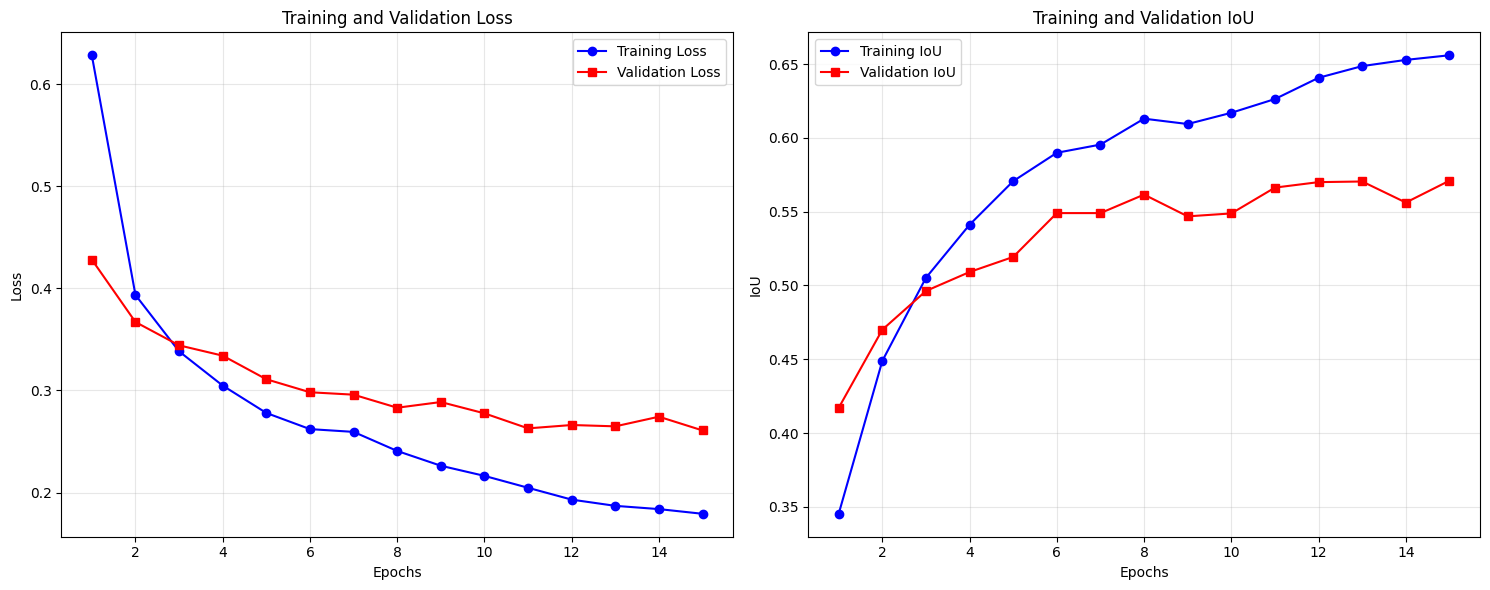

=== TRAINING SUMMARY ===
Final Training Loss: 0.1791
Final Validation Loss: 0.2608
Final Training IoU: 0.6560
Final Validation IoU: 0.5710
Best Validation IoU: 0.5710 (Epoch 15)
Best Training IoU: 0.6560 (Epoch 15)




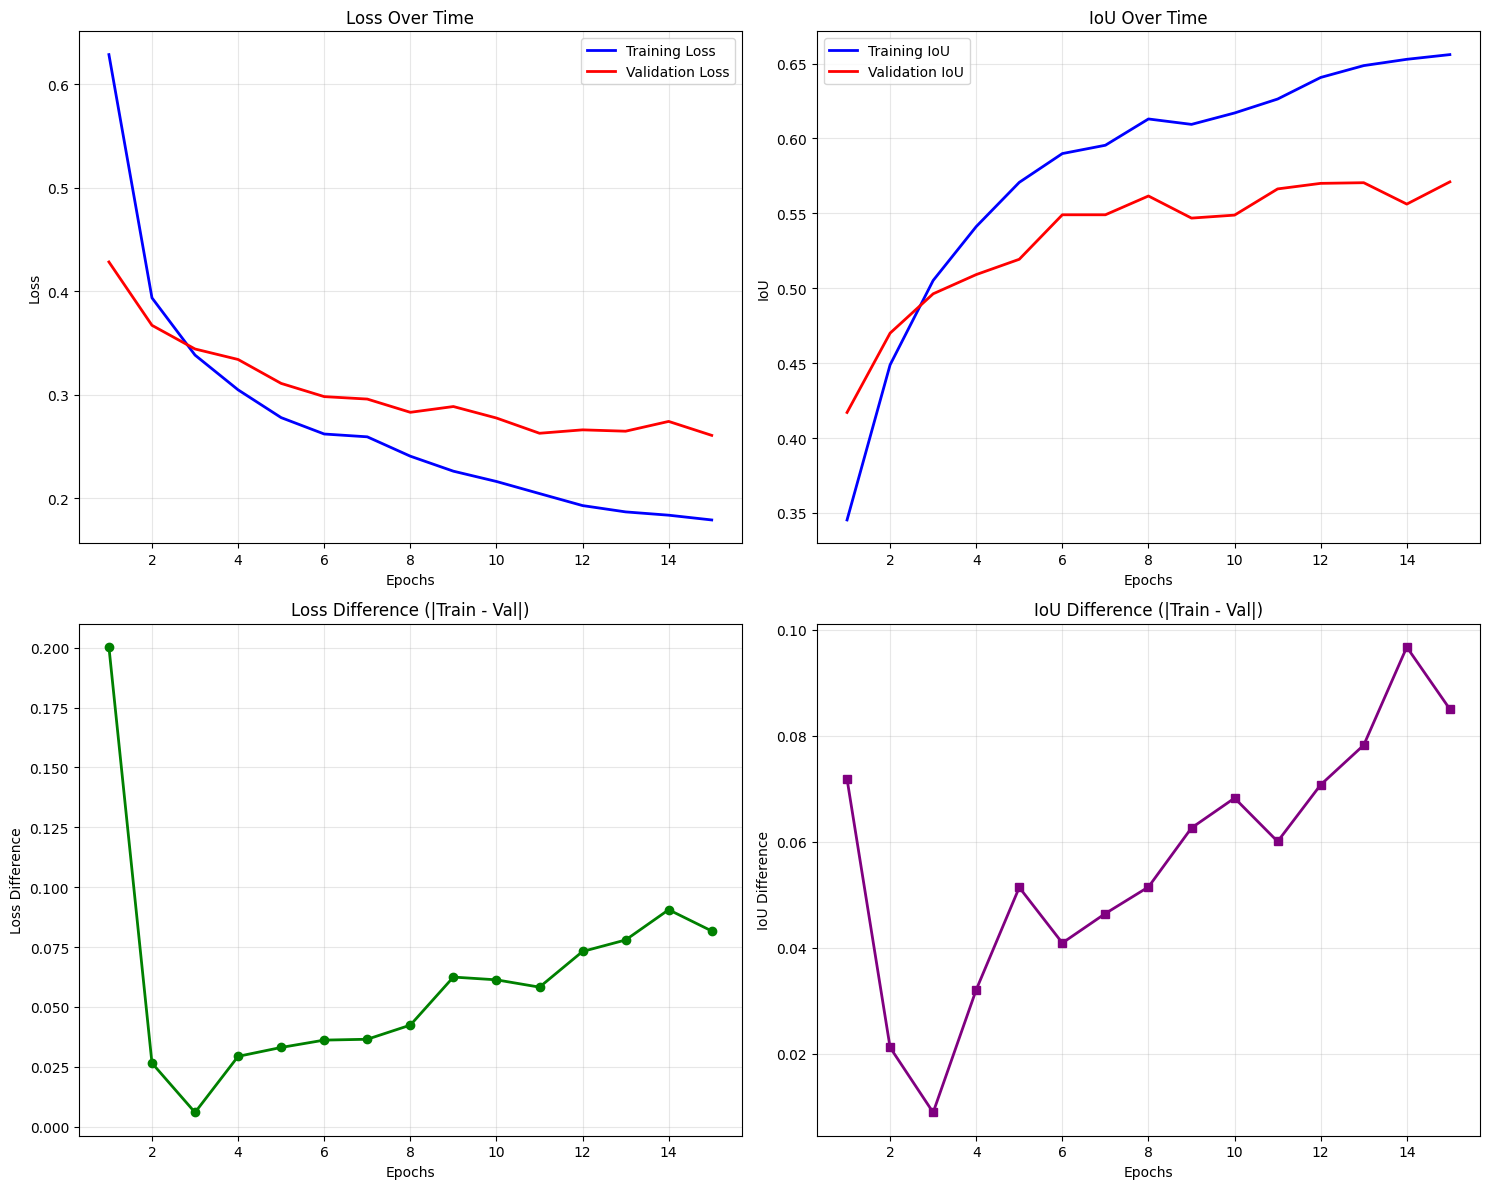

=== DETAILED ANALYSIS ===
Average Loss Difference: 0.0610
Average IoU Difference: 0.0564
⚠️  High IoU difference - model may not generalize well


In [ ]:
plot_training_metrics_from_checkpoint(15)

# Resume Training

In [16]:
# Load the last model to resume training
epoch_to_resume = 16  
last_model_path = f"models/deeplabv3_resnet50_epoch_{epoch_to_resume}.pth"
print (f"Loading model from: {last_model_path}")
checkpoint = torch.load(last_model_path, map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

Loading model from: models/deeplabv3_resnet50_epoch_16.pth


In [ ]:
# Resume Training
# Epoch 16 was runned alone for a test
start_epoch = checkpoint['epoch']
additional_epochs = 4
total_epochs = start_epoch + additional_epochs

print(f"Resuming training from epoch {start_epoch} to {total_epochs}")

# Load metrics for plotting
train_losses = checkpoint['train_losses']
train_ious = checkpoint['train_ious']
val_losses = checkpoint['val_losses']
val_ious = checkpoint['val_ious']

# Track best validation IoU for saving best model
best_val_iou = max(val_ious)  # Use best from previous training
print(f"Previous best validation IoU: {best_val_iou:.4f}")

new_seed = SEED + start_epoch  


syn_train_dataloader = DataLoader(
    syn_train_dataset,  # Keep the same dataset split
    batch_size=batch_size,
    shuffle=True,
    generator=torch.Generator().manual_seed(new_seed)
)

syn_val_dataloader = DataLoader(
    syn_val_dataset,  # Keep the same dataset split
    batch_size=batch_size,
    shuffle=True,  
    generator=torch.Generator().manual_seed(new_seed)
)


start = time.time()
set_seeds(SEED + start_epoch) # different seed 
for epoch in range(start_epoch, total_epochs):
    print(f"Epoch {epoch+1}/{total_epochs}")
    
    # Train and validate in one go
    train_loss, train_iou, val_loss, val_iou = train_and_validate_epoch(
        model, syn_train_dataloader, syn_val_dataloader, optimizer, criterion
    )
    
    # Store metrics
    train_losses.append(train_loss)  
    train_ious.append(train_iou)
    val_losses.append(val_loss)
    val_ious.append(val_iou)
    
    # Print results
    print(f"Train Loss: {train_loss:.4f} | Train IoU: {train_iou:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val IoU: {val_iou:.4f}")
    
    # Save checkpoint after each epoch
    checkpoint = {
        "epoch": epoch + 1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "train_loss": train_loss,
        "train_iou": train_iou,
        "val_loss": val_loss,
        "val_iou": val_iou,
        "train_losses": train_losses,
        "train_ious": train_ious,
        "val_losses": val_losses,
        "val_ious": val_ious,
        "num_classes": NUM_CLASSES,
        "learning_rate": LR,
    }
    
    
    # Save best model based on validation IoU
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        best_model_path = "models/deeplabv3_resnet50_best_model.pth"
        torch.save(checkpoint, best_model_path)
        print(f"New best model saved: {best_model_path} (Val IoU: {val_iou:.4f})")
    
    checkpoint_path = f"models/deeplabv3_resnet50_epoch_{epoch+1}.pth"
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")

    # Delete old checkpoints if they exist
    checkpoint_delete = f"models/deeplabv3_resnet50_epoch_{epoch}.pth"
    if os.path.exists(checkpoint_delete):
        os.remove(checkpoint_delete)
        print(f"Deleted old checkpoint: {checkpoint_delete}")
    
    print("-" * 50)
end = time.time()
print(f"\nTraining completed in {end - start:.2f} seconds, with {additional_epochs} additional epochs.")
print(f"Best validation IoU: {best_val_iou:.4f}")
print(f"Final model saved as: models/deeplabv3_resnet50_epoch_{total_epochs}.pth")
print(f"Best model saved as: models/deeplabv3_resnet50_best_model.pth")

Resuming training from epoch 16 to 20
Previous best validation IoU: 0.5710
Epoch 17/20


Validating: 100%|██████████| 157/157 [02:29<00:00,  1.05it/s]


Train Loss: 0.1863 | Train IoU: 0.6464
Val Loss: 0.2572 | Val IoU: 0.5690
Checkpoint saved: models/deeplabv3_resnet50_epoch_17.pth
Deleted old checkpoint: models/deeplabv3_resnet50_epoch_16.pth
--------------------------------------------------
Epoch 18/20


Validating: 100%|██████████| 157/157 [02:32<00:00,  1.03it/s]


Train Loss: 0.1784 | Train IoU: 0.6528
Val Loss: 0.2694 | Val IoU: 0.5615
Checkpoint saved: models/deeplabv3_resnet50_epoch_18.pth
Deleted old checkpoint: models/deeplabv3_resnet50_epoch_17.pth
--------------------------------------------------
Epoch 19/20


Validating: 100%|██████████| 157/157 [02:34<00:00,  1.02it/s]


Train Loss: 0.1740 | Train IoU: 0.6595
Val Loss: 0.2554 | Val IoU: 0.5776
New best model saved: models/deeplabv3_resnet50_best_model.pth (Val IoU: 0.5776)
Checkpoint saved: models/deeplabv3_resnet50_epoch_19.pth
Deleted old checkpoint: models/deeplabv3_resnet50_epoch_18.pth
--------------------------------------------------
Epoch 20/20


Validating: 100%|██████████| 157/157 [02:37<00:00,  1.00s/it]


Train Loss: 0.1721 | Train IoU: 0.6587
Val Loss: 0.2692 | Val IoU: 0.5655
Checkpoint saved: models/deeplabv3_resnet50_epoch_20.pth
Deleted old checkpoint: models/deeplabv3_resnet50_epoch_19.pth
--------------------------------------------------

Training completed in 9793.65 seconds, with 4 additional epochs.
Best validation IoU: 0.5776
Final model saved as: models/deeplabv3_resnet50_epoch_20.pth
Best model saved as: models/deeplabv3_resnet50_best_model.pth


Epoch 16/20

Training: 100%|██████████| 938/938 [37:40<00:00,  2.41s/it]

Validating: 100%|██████████| 157/157 [02:29<00:00,  1.05it/s]

Train Loss: 0.2008  |   Train IoU: 0.6274
Val Loss: 0.2639 | Val IoU: 0.5610
Checkpoint saved: models/deeplabv3_resnet50_epoch_16.pth
Deleted old checkpoint: models/deeplabv3_resnet50_epoch_15.pth

Epoch 17/20

Training: 100%|██████████| 938/938 [37:47<00:00,  2.42s/it]

Validating: 100%|██████████| 157/157 [02:29<00:00,  1.05it/s]

Train Loss: 0.1863 | Train IoU: 0.6464
Val Loss: 0.2572 | Val IoU: 0.5690

Checkpoint saved: models/deeplabv3_resnet50_epoch_17.pth
Deleted old checkpoint: models/deeplabv3_resnet50_epoch_16.pth


Epoch 18/20
Training: 100%|██████████| 938/938 [37:50<00:00,  2.42s/it]

Validating: 100%|██████████| 157/157 [02:32<00:00,  1.03it/s]

Train Loss: 0.1784 | Train IoU: 0.6528
Val Loss: 0.2694 | Val IoU: 0.5615

Checkpoint saved: models/deeplabv3_resnet50_epoch_18.pth
Deleted old checkpoint: models/deeplabv3_resnet50_epoch_17.pth


Epoch 19/20
Training: 100%|██████████| 938/938 [38:32<00:00,  2.47s/it]

Validating: 100%|██████████| 157/157 [02:34<00:00,  1.02it/s]

Train Loss: 0.1740 | Train IoU: 0.6595
Val Loss: 0.2554 | Val IoU: 0.5776

New best model saved: models/deeplabv3_resnet50_best_model.pth (Val IoU: 0.5776)
Checkpoint saved: models/deeplabv3_resnet50_epoch_19.pth
Deleted old checkpoint: models/deeplabv3_resnet50_epoch_18.pth


Epoch 20/20
Training: 100%|██████████| 938/938 [38:44<00:00,  2.48s/it]

Validating: 100%|██████████| 157/157 [02:37<00:00,  1.00s/it]

Train Loss: 0.1721 | Train IoU: 0.6587
Val Loss: 0.2692 | Val IoU: 0.5655

Checkpoint saved: models/deeplabv3_resnet50_epoch_20.pth
Deleted old checkpoint: models/deeplabv3_resnet50_epoch_19.pth



Training completed in 9793.65 seconds, with 4 additional epochs.
Best validation IoU: 0.5776
Final model saved as: models/deeplabv3_resnet50_epoch_20.pth
Best model saved as: models/deeplabv3_resnet50_best_model.pth

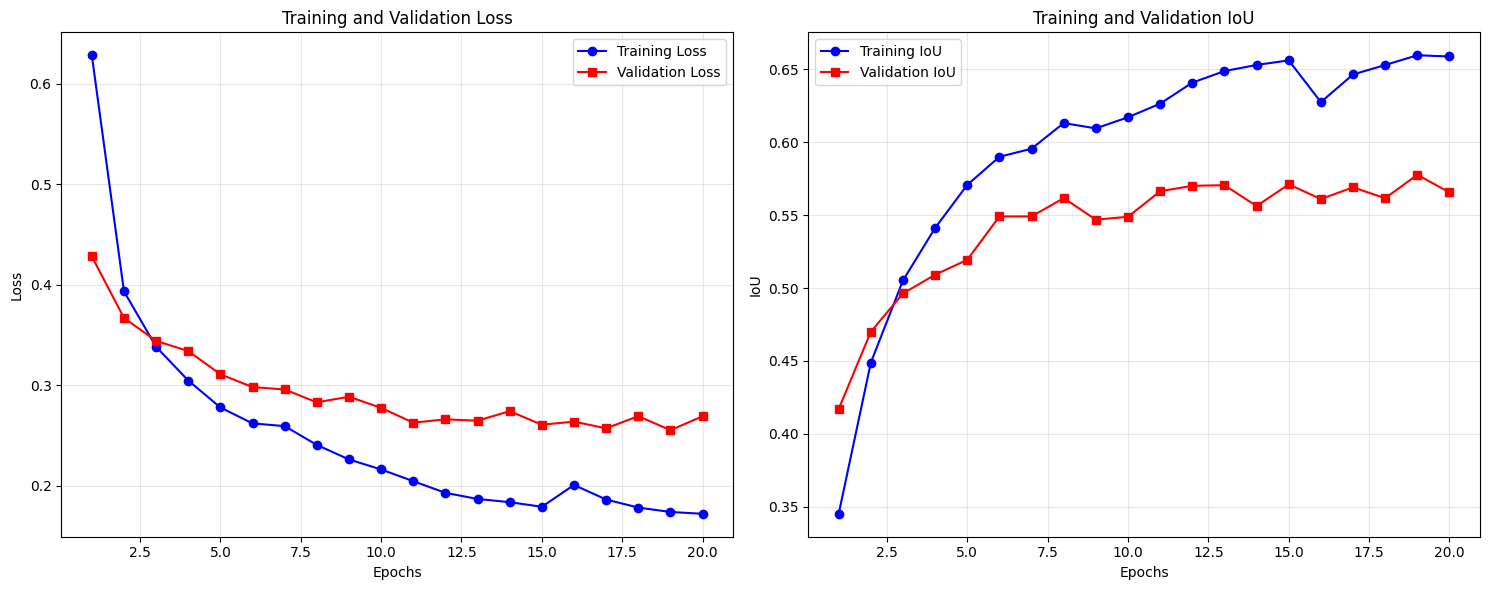

=== TRAINING SUMMARY ===
Final Training Loss: 0.1721
Final Validation Loss: 0.2692
Final Training IoU: 0.6587
Final Validation IoU: 0.5655
Best Validation IoU: 0.5776 (Epoch 19)
Best Training IoU: 0.6595 (Epoch 19)


In [20]:
plot_training_metrics_from_checkpoint(total_epochs)

now from 20 to 25

In [14]:
# Load the last model to resume training
epoch_to_resume = 20  
last_model_path = f"models/deeplabv3_resnet50_epoch_{epoch_to_resume}.pth"
print (f"Loading model from: {last_model_path}")
checkpoint = torch.load(last_model_path, map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

Loading model from: models/deeplabv3_resnet50_epoch_20.pth


In [15]:
# Resume Training
start_epoch = checkpoint['epoch']
additional_epochs = 5
total_epochs = start_epoch + additional_epochs

print(f"Resuming training from epoch {start_epoch} to {total_epochs}")

# Load metrics for plotting
train_losses = checkpoint['train_losses']
train_ious = checkpoint['train_ious']
val_losses = checkpoint['val_losses']
val_ious = checkpoint['val_ious']

# Track best validation IoU for saving best model
best_val_iou = max(val_ious)  # Use best from previous training
print(f"Previous best validation IoU: {best_val_iou:.4f}")

new_seed = SEED + start_epoch  

# Create new dataloaders with the new seed but using the same dataset splits
syn_train_dataloader = DataLoader(
    syn_train_dataset,  # Keep the same dataset split
    batch_size=batch_size,
    shuffle=True,
    generator=torch.Generator().manual_seed(new_seed)
)

syn_val_dataloader = DataLoader(
    syn_val_dataset,  # Keep the same dataset split
    batch_size=batch_size,
    shuffle=True,  
    generator=torch.Generator().manual_seed(new_seed)
)


start = time.time()
set_seeds(new_seed) # different seed 
for epoch in range(start_epoch, total_epochs):
    print(f"Epoch {epoch+1}/{total_epochs}")
    
    # Train and validate in one go
    train_loss, train_iou, val_loss, val_iou = train_and_validate_epoch(
        model, syn_train_dataloader, syn_val_dataloader, optimizer, criterion
    )
    
    # Store metrics
    train_losses.append(train_loss)  
    train_ious.append(train_iou)
    val_losses.append(val_loss)
    val_ious.append(val_iou)
    
    # Print results
    print(f"Train Loss: {train_loss:.4f} | Train IoU: {train_iou:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val IoU: {val_iou:.4f}")
    
    # Save checkpoint after each epoch
    checkpoint = {
        "epoch": epoch + 1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "train_loss": train_loss,
        "train_iou": train_iou,
        "val_loss": val_loss,
        "val_iou": val_iou,
        "train_losses": train_losses,
        "train_ious": train_ious,
        "val_losses": val_losses,
        "val_ious": val_ious,
        "num_classes": NUM_CLASSES,
        "learning_rate": LR,
    }
    
    
    # Save best model based on validation IoU
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        best_model_path = "models/deeplabv3_resnet50_best_model.pth"
        torch.save(checkpoint, best_model_path)
        print(f"New best model saved: {best_model_path} (Val IoU: {val_iou:.4f})")
    
    checkpoint_path = f"models/deeplabv3_resnet50_epoch_{epoch+1}.pth"
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")

    # Delete old checkpoints if they exist
    checkpoint_delete = f"models/deeplabv3_resnet50_epoch_{epoch}.pth"
    if os.path.exists(checkpoint_delete):
        os.remove(checkpoint_delete)
        print(f"Deleted old checkpoint: {checkpoint_delete}")
    
    print("-" * 50)
end = time.time()
print(f"\nTraining completed in {end - start:.2f} seconds, with {additional_epochs} additional epochs.")
print(f"Best validation IoU: {best_val_iou:.4f}")
print(f"Final model saved as: models/deeplabv3_resnet50_epoch_{total_epochs}.pth")
print(f"Best model saved as: models/deeplabv3_resnet50_best_model.pth")

Resuming training from epoch 20 to 25
Previous best validation IoU: 0.5776
Epoch 21/25


Validating: 100%|██████████| 157/157 [02:29<00:00,  1.05it/s]


Train Loss: 0.1745 | Train IoU: 0.6586
Val Loss: 0.2838 | Val IoU: 0.5643
Checkpoint saved: models/deeplabv3_resnet50_epoch_21.pth
Deleted old checkpoint: models/deeplabv3_resnet50_epoch_20.pth
--------------------------------------------------
Epoch 22/25


Validating: 100%|██████████| 157/157 [02:31<00:00,  1.04it/s]


Train Loss: 0.1701 | Train IoU: 0.6678
Val Loss: 0.2659 | Val IoU: 0.5721
Checkpoint saved: models/deeplabv3_resnet50_epoch_22.pth
Deleted old checkpoint: models/deeplabv3_resnet50_epoch_21.pth
--------------------------------------------------
Epoch 23/25


Validating: 100%|██████████| 157/157 [02:33<00:00,  1.02it/s]


Train Loss: 0.1710 | Train IoU: 0.6661
Val Loss: 0.2928 | Val IoU: 0.5445
Checkpoint saved: models/deeplabv3_resnet50_epoch_23.pth
Deleted old checkpoint: models/deeplabv3_resnet50_epoch_22.pth
--------------------------------------------------
Epoch 24/25


Validating: 100%|██████████| 157/157 [02:38<00:00,  1.01s/it]


Train Loss: 0.1726 | Train IoU: 0.6627
Val Loss: 0.2642 | Val IoU: 0.5757
Checkpoint saved: models/deeplabv3_resnet50_epoch_24.pth
Deleted old checkpoint: models/deeplabv3_resnet50_epoch_23.pth
--------------------------------------------------
Epoch 25/25


Validating: 100%|██████████| 157/157 [02:40<00:00,  1.03s/it]


Train Loss: 0.1694 | Train IoU: 0.6684
Val Loss: 0.2517 | Val IoU: 0.5830
New best model saved: models/deeplabv3_resnet50_best_model.pth (Val IoU: 0.5830)
Checkpoint saved: models/deeplabv3_resnet50_epoch_25.pth
Deleted old checkpoint: models/deeplabv3_resnet50_epoch_24.pth
--------------------------------------------------

Training completed in 12398.08 seconds, with 5 additional epochs.
Best validation IoU: 0.5830
Final model saved as: models/deeplabv3_resnet50_epoch_25.pth
Best model saved as: models/deeplabv3_resnet50_best_model.pth


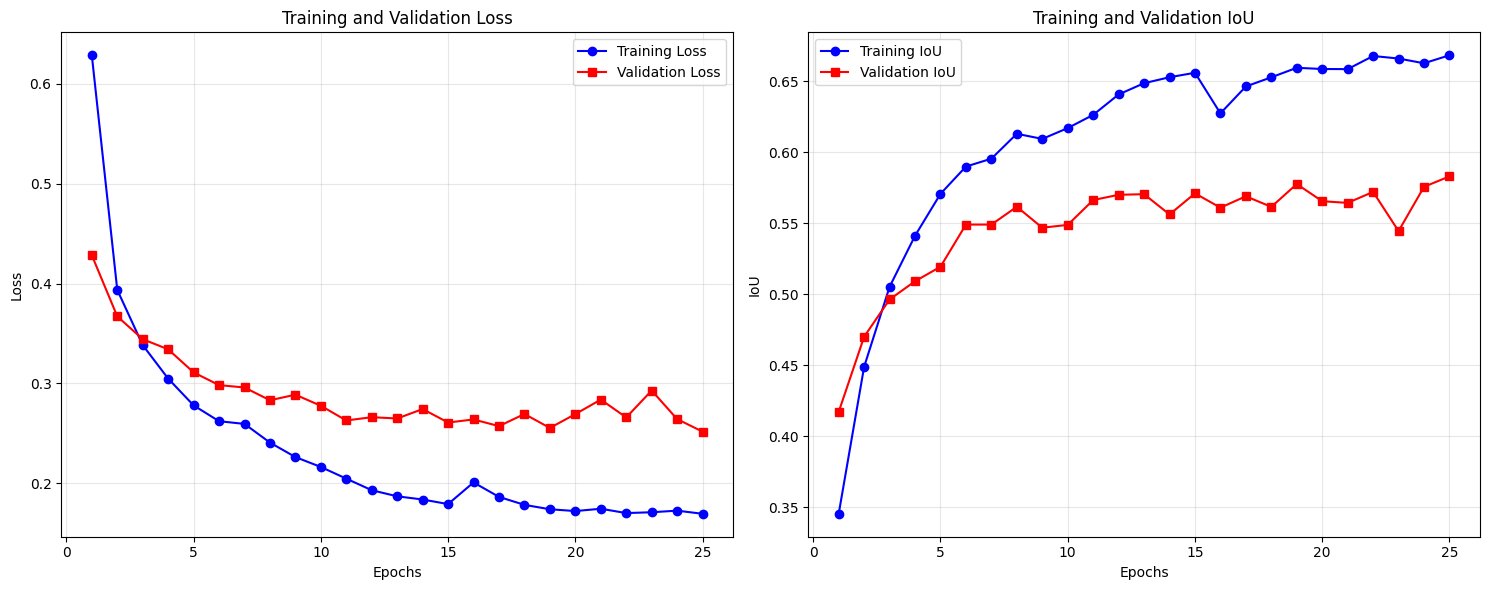

=== TRAINING SUMMARY ===
Final Training Loss: 0.1694
Final Validation Loss: 0.2517
Final Training IoU: 0.6684
Final Validation IoU: 0.5830
Best Validation IoU: 0.5830 (Epoch 25)
Best Training IoU: 0.6684 (Epoch 25)


In [16]:
plot_training_metrics_from_checkpoint(total_epochs)

Visualizing segmentation results...


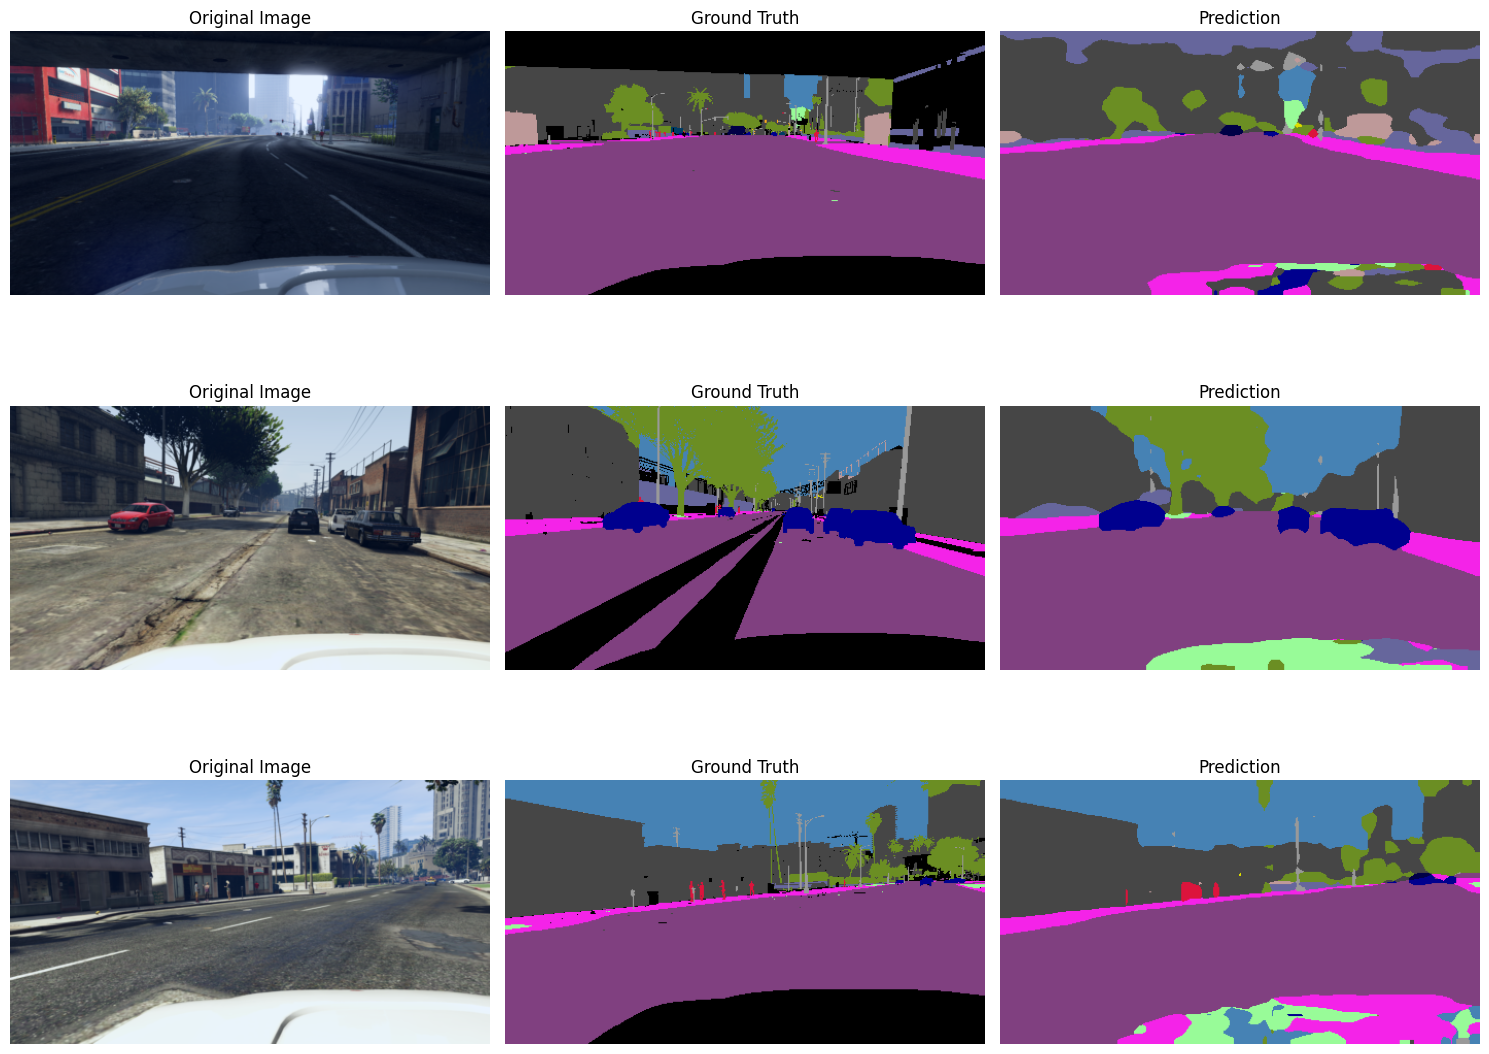


Training examples:


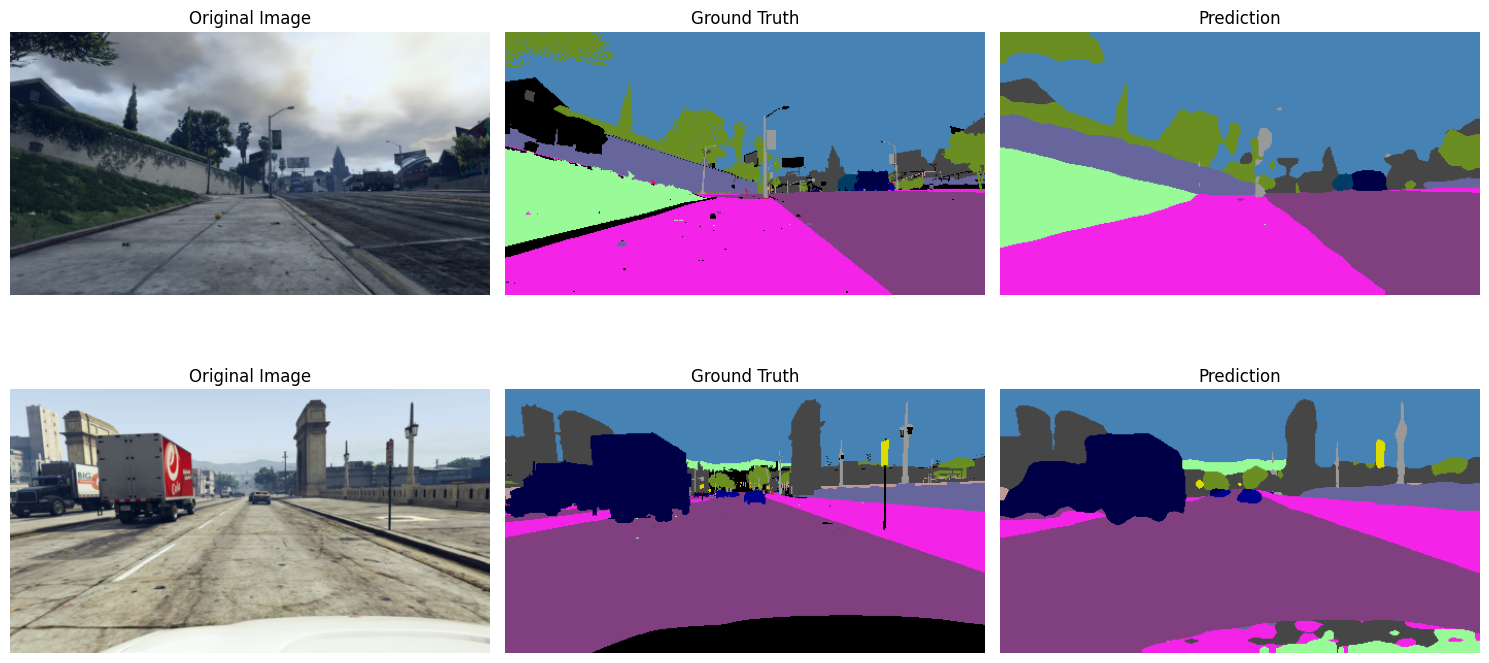

In [18]:
# Visualize segmentation results on validation set
print("Visualizing segmentation results...")
visualize_segmentation(model, syn_val_dataloader, num_samples=3)

# Also show some training examples for comparison
print("\nTraining examples:")
visualize_segmentation(model, syn_train_dataloader, num_samples=2)